In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

# style: darkgrid, whitegrid, dark, white, ticks
# context: talk, paper, notebook, poster
sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')


In [16]:
def ReadDG(file_path: str, sep: str = None) -> dict:
    """Read Directed Graph

    Returns:
        dict: Adjacency list.
    """
    V = {}
    with open(file_path) as f:
        for l in f:
            try:
                u, v = map(int, l.split(sep))
            except:
                continue
            d = {'in': set(), 'out': set()}
            V.setdefault(u, d)['out'].add(v)
            V.setdefault(v, d)['in'].add(u)
    return V


def IC(V: dict, S: set, p: float, r: int) -> int:
    """Independent Cascade Model

    Args:
        V (dict): Adjacency list.
        S (set): Initial active set.
        p (float): Edge activation probability.
        r (int): Number of realizations.

    Returns:
        int: Expected cascade size.
    """
    f = 0  # Expected cascade size
    for ri in range(r):
        Si = S.copy()  # Active set in realization i
        Si_new = S.copy()  # Newly activated nodes
        while Si_new:
            # Activate neighbors of each active node.
            new_neighbors = set()
            for u in Si_new:
                for v in V[u]['out']:
                    if random.random() < p:
                        new_neighbors.add(v)
            Si_new = new_neighbors - Si
            Si |= Si_new
        f += len(Si)
    return f


def Greedy(V: dict, k: int, p: float, r: int) -> tuple:
    """Influence Maximization through Greedy Algorithm
    Find most the influential set S of size k.

    Args:
        V (dict): Adjacency list.
        k (int): Size of influential set.
        p (float): Edge activation probability.
        r (int): Number of realizations.

    Returns:
        tuple: influential set, computation times
    """
    S = set()
    f = 0
    ctimes, stime = [], time.time()

    for ki in range(k):
        # Find the remaining node with largest marginal gain.
        rest = set(V.keys()) - S
        best_gain, best_node = 0, -1
        for u in rest:
            gu = IC(V, S | {u}, p, r) - f
            if gu > best_gain:
                best_gain, best_node = gu, u
        S.add(best_node)
        f += best_gain
        ctimes.append(time.time() - stime)
    return S, ctimes


def CELF(V: dict, k: int, p: float, r: int) -> tuple:
    """Influence Maximization through CELF Algorithm
    Find most the influential set S of size k.

    Args:
        V (dict): Adjacency list.
        k (int): Size of influential set.
        p (float): Edge activation probability.
        r (int): Number of realizations.

    Returns:
        tuple: influential set, computation times
    """

    # Perform the first iteration through greedy approach.
    stime = time.time()
    gains = [(u, IC(V, {u}, p, r)) for u in V]
    gains.sort(key=lambda x: x[1], reverse=True)
    S = {gains[0][0]}
    f = gains[0][1]
    gains = gains[1:]
    ctimes = [time.time() - stime]

    for ki in range(1, k):
        top = -1
        while top != gains[0][0]:
            top = gains[0][0]
            gains[0] = (top, IC(V, S | {top}, p, r) - f)
            gains.sort(key=lambda x: x[1], reverse=True)
        S.add(gains[0][0])
        f += gains[0][1]
        ctimes.append(time.time() - stime)
        gains = gains[1:]

    return S, ctimes


In [17]:
# Astro Physics collaboration network
# https://snap.stanford.edu/data/ca-AstroPh.html
V = ReadDG('datasets/CA-AstroPh.txt')

In [18]:
K = 10
P = 0.001
R = 100

random.seed(2)
gr_set, gr_times = Greedy(V, k=K, p=P, r=R)
ce_set, ce_times = CELF(V, k=K, p=P, r=R)

Greedy result: {93504, 62821, 81286, 67303, 37653, 64054, 92790, 124566, 35290, 53213}
CELF result: {44866, 62821, 34608, 53213, 67410, 92790, 115607, 50808, 45530, 38109}
Similar nodes: {53213, 62821, 92790}
Greedy computation time: 3524.07s
CELF computation time: 11.82s


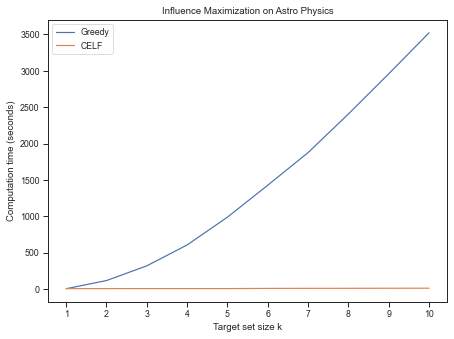

In [21]:
print("Greedy result:", gr_set)
print("CELF result:", ce_set)
print("Similar nodes:", gr_set & ce_set)
print("Greedy computation time:", f"{gr_times[-1]:.2f}s")
print("CELF computation time:", f"{ce_times[-1]:.2f}s")

x = list(range(1, K+1))
ax = sns.lineplot(x=x, y=gr_times, label="Greedy")
sns.lineplot(x=x, y=ce_times, label="CELF", ax=ax)
ax.set(
    title="Influence Maximization on Astro Physics",
    xlabel="Target set size k",
    ylabel="Computation time (seconds)",
    xticks=x,
)
plt.savefig('q4.png')
plt.show()
